#### **1. Thêm các thư viện cần thiết và đọc dữ liệu**
##### ***1.1. Thư viện cần thiết***

In [2]:
# Thêm tiện ích để xem dữ liệu trực quan hơn:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Thêm các thư viện cần thiết:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import re
import math
import eli5
import os
import time
from datetime import datetime
import joblib

#dataset pre-processing realated imports
import sklearn
from eli5.sklearn import PermutationImportance
from urllib.parse import urlparse
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#imports related to classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier

#DNN imports
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau

#Explainability imports
from sklearn.inspection import PartialDependenceDisplay

##### ***1.2. Lấy đường dẫn dữ liệu***

In [3]:
# Kaggle:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('./Data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./Data\csic_database.csv


##### ***1.3. Đọc dữ liệu và khảo sát dữ liệu***

In [4]:
# Viết một hàm nhận một DataFrame để khảo sát các cột:
def getUniqueValues(df, threshold=5):
    """
    Hàm lấy các giá trị unique trong các cột của DataFrame khi số lượng unique nhỏ hơn một ngưỡng nhất định.

    Args:
        df: DataFrame cần xử lý
        threshold: Ngưỡng số lượng unique tối đa

    Returns:
        Một dictionary chứa tên cột và các giá trị unique tương ứng.
    """

    unique_values = []
    for col in df.columns:
        unique_counts = df[col].nunique()
        if unique_counts < threshold:
            unique_values.append(df[col].unique().tolist())
        else:
            unique_values.append([])
    return unique_values

def infoDF(df, threshold=5):
    # Kiểm tra các thuộc tính:
    n_features = df.shape[1]
    n_samples = df.shape[0]
    # print(f"Số đặc trưng (cột):{n_features};            Số mẫu (hàng): {n_samples}")

    # Biến lưu giữ thông tin từng features trong dữ liệu:
    info_csic_df = {
        'Column': df.columns,
        'Non-Null Count': df.notnull().sum(),
        'Dtype': df.dtypes,
        'Unique Count': [df[col].nunique() for col in df.columns],
        'Unique values': getUniqueValues(df, threshold=threshold) 
    }
    info_csic_df = pd.DataFrame(info_csic_df)
    return n_features, n_samples, info_csic_df

In [5]:
path_file = "./Data/csic_database.csv"
csic_df = pd.read_csv(path_file)
# Đổi tên cột thứ nhất từ 'Unnamed: 0' thành 'Label'
csic_df.rename(columns={csic_df.columns[0]: 'Class'}, inplace=True)
csic_df.rename(columns={csic_df.columns[13]: 'Content_length'}, inplace=True)

# Kiểm tra các thuộc tính:
n_features, n_samples, info_csic_df = infoDF(csic_df)
print(f"Số đặc trưng (cột):{n_features};            Số mẫu (hàng): {n_samples}")
print(info_csic_df[['Column', 'Dtype', 'Non-Null Count', 'Unique Count', 'Unique values']].to_string(index=False))

Số đặc trưng (cột):17;            Số mẫu (hàng): 61065
         Column  Dtype  Non-Null Count  Unique Count                                                                                              Unique values
          Class object           61065             2                                                                                        [Normal, Anomalous]
         Method object           61065             3                                                                                           [GET, POST, PUT]
     User-Agent object           61065             1                                  [Mozilla/5.0 (compatible; Konqueror/3.5; Linux) KHTML/3.5.8 (like Gecko)]
         Pragma object           61065             1                                                                                                 [no-cache]
  Cache-Control object           61065             1                                                                                             

Như vậy, có thể thấy, dữ liệu ban đầu bao gồm **17** trường dữ liệu với **8** trường dữ liệu chỉ có 1 giá trị duy nhất. Hơn nữa, dễ thấy rằng, ta có **3** trường dữ liệu bị thiếu, tuy nhiên, ta cần xử lý, không nên loại bỏ các trường này.

Việc loại bỏ các mẫu có giá trị thiếu sẽ dẫn đến việc mất đi thông tin quan trọng về các phương thức yêu cầu khác, và vì vậy, lựa chọn này không được khuyến khích.

Tiếp theo, trường **cookie** có đến **61065** giá trị unique, do đó, không có ý nghĩa trong việc phân loại.

Ngoài ra, tại trường dữ liệu **connection** ta thấy rằng có 2 giá trị unique nhưng về ngữ nghĩa lại giống nhau: [close, Connection: close]. Do đó, có thể coi nó như một trường dữ liệu có 1 giá trị duy nhất.

Đặc trưng **classification**, đã được chuẩn hóa từ đặc trưng **Class**. Do đó, ta sẽ sử dụng đặc trưng này để phân loại
##### ***1.4. Biểu diễn phân loại từ Feature "Class":***

<Axes: xlabel='Class', ylabel='count'>

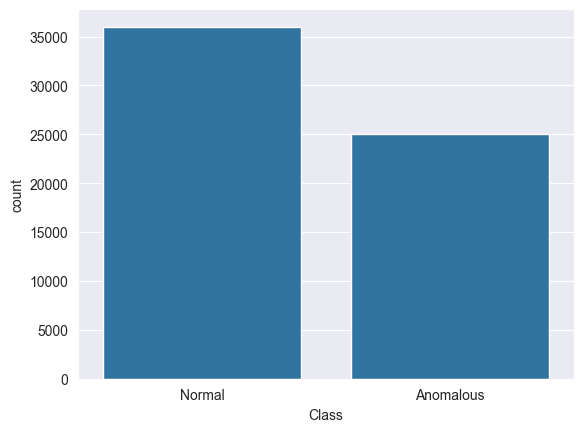

In [6]:
sns.set_style('darkgrid')
sns.countplot(data=csic_df, x='Class')

##### ***1.5. Clone trường dữ liệu cần thiết để xử lý***
Tổng cộng, ta có **9** trường dữ liệu có ý nghĩa phân tích, gồm:

**['Class','Method', 'host', 'Accept', 'content_length', 'content',
                'classification', 'URL']**


In [7]:
# Loại bỏ các đặc trưng không có ngữ nghĩa (chỉ có 1 giá trị) gồm: ['User-Agent', 'Pragma', 'Cache-Control', 'Accept-encoding', 'Accept-charset', 'language', 'content-type', 'cookie'] 
# Tối ưu hóa các đặc trưng, lấy ra các đặc trưng cần thiết
feature_names=[ 'Class','Method', 'host', 'Accept', 'Content_length', 'content',
                'classification', 'URL']

X = csic_df[feature_names]
# Kiểm tra các thuộc tính:
n_xfeatures, n_xsamples, info_x = infoDF(X)
print(f"Số đặc trưng (cột):{n_xfeatures};            Số mẫu (hàng): {n_xsamples}")
print(info_x[['Column', 'Dtype', 'Non-Null Count', 'Unique Count', 'Unique values']].to_string(index=False))

Số đặc trưng (cột):8;            Số mẫu (hàng): 61065
        Column  Dtype  Non-Null Count  Unique Count                                                                                              Unique values
         Class object           61065             2                                                                                        [Normal, Anomalous]
        Method object           61065             3                                                                                           [GET, POST, PUT]
          host object           61065             2                                                                           [localhost:8080, localhost:9090]
        Accept object           60668             1 [text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5, nan]
Content_length object           17977           382                                                                                                    

#### **2. Thực hiện xử lý các trường dữ liệu**
##### ***2.1. Phân loại thành biến Category và Continous***

In [8]:
# Lấy ra các cột thuộc loại biến Category:
temp = (X.dtypes == 'object')           # <class 'pandas.core.series.Series'>
object_Xcols=list(temp[temp].index)
print(f"Các feature thuộc biến phân loại: {object_Xcols}\nSố lượng: {len(object_Xcols)}")

Các feature thuộc biến phân loại: ['Class', 'Method', 'host', 'Accept', 'Content_length', 'content', 'URL']
Số lượng: 7


##### ***2.2. Tiền xử lý feature: 'Content_length'***

In [9]:
temp = X['Content_length']
print(f"Số lượng: {len(temp)};   Có nghĩa: {temp.count()};      Null: {len(temp)-temp.count()}")
X['Content_length'].head(10)

Số lượng: 61065;   Có nghĩa: 17977;      Null: 43088


0                   NaN
1                   NaN
2    Content-Length: 68
3                   NaN
4    Content-Length: 63
5                   NaN
6     Content-Length: 4
7                   NaN
8                   NaN
9    Content-Length: 33
Name: Content_length, dtype: object

Có thể thấy dữ liệu đang chứa một cụm từ: 'Content-Length: ' trong mỗi trường giá trị. Do đó, ta cần loại bỏ dữ liệu này. Ý tưởng tốt nhất như sau:
- B1: Chuyển đổi các giá trị về type=str
- B2: Sử dụng biểu thức chính quy, trích xuất dữ liệu là số và gán ngược lại. Những biến là NaN (Null) thì chuyển thành 0. Về bản chất, các gói này không có nội dung
- B3: Chuyển đổi các giá trị về lại type=float64

In [10]:
pd.options.mode.chained_assignment = None # Tắt cảnh báo
# X.loc[:, 'Content_length'] = X['Content_length'].astype(str)
# X.loc[:, 'Content_length'] = X['Content_length'].str.extract(r'(\d+)')
# X.loc[:, 'Content_length'] = pd.to_numeric(X['Content_length'], errors='coerce').fillna(0)

X['Content_length'] = X['Content_length'].astype(str)
X['Content_length'] = X['Content_length'].str.extract(r'(\d+)')
X['Content_length'] = pd.to_numeric(X['Content_length'], errors='coerce').fillna(0) # pd.to_numeric() chuyển các giá trị trong cột 'content_length' thành numeric. Tham số errors='coerce' giúp xử lý các giá trị không thể chuyển đổi thành số thành NaN. Sau đó, .fillna(0) thay thế các giá trị NaN bằng số 0.
# X['Content_length'].head(10)

Phương thức **GET** không cần gửi dữ liệu trong phần nội dung (body), do đó không có chiều dài nội dung. Xem số lượng hàng dữ liệu như này có nhiều không?

In [11]:
filter_GET0 = X.loc[(X['Method'] == 'GET') & (X['Content_length']==0)]
filter_GET02 = X.loc[X['Method'] == 'GET', 'Content_length']
print(f'Số lượng GET 0: {len(filter_GET0)}/{X.shape[0]}')
print(f'Số lượng GET2 0: {len(filter_GET02)}/{X.shape[0]}')
# => Kết quả giống nhau.

Số lượng GET 0: 43088/61065
Số lượng GET2 0: 43088/61065


##### ***2.3. Tiền xử lý: URL***
Trường dữ liệu **'URL'** là trường dữ liệu đầy đủ, bao gồm **61065/61065** giá trị với **13498** giá trị là unique. 

Dạng dữ liệu: `<link> <versionHTTP>`: http://localhost:8080/tienda1/publico/anadir.jsp HTTP/1.1


In [12]:
# Xem top 5 loại URL phổ biến với số lượng giá trị của nó:
url_counts = X['URL'].value_counts()
most_common_urls = url_counts.head(5)

print("Most common URLs:")
for i, (url, count) in enumerate(most_common_urls.items(), 1):
    print(f"{i}. URL: {url} - Count: {count}")

Most common URLs:
1. URL: http://localhost:8080/tienda1/publico/anadir.jsp HTTP/1.1 - Count: 2441
2. URL: http://localhost:8080/tienda1/publico/autenticar.jsp HTTP/1.1 - Count: 2422
3. URL: http://localhost:8080/tienda1/publico/registro.jsp HTTP/1.1 - Count: 2417
4. URL: http://localhost:8080/tienda1/miembros/editar.jsp HTTP/1.1 - Count: 2412
5. URL: http://localhost:8080/tienda1/publico/pagar.jsp HTTP/1.1 - Count: 2379


##### *2.3.1. Phương thức phân tích dữ liệu*
Dữ liệu URL trên sẽ được phân tích thành các feature nhỏ hơn. Quy tình xử lý được biểu diễn bởi đoạn code bên dưới. Mục đích chính của đoạn code này là phân tích các URL để tìm kiếm các đặc điểm có thể cho thấy các hoạt động đáng ngờ hoặc độc hại. Các hàm trong đoạn code tính toán nhiều thông số khác nhau từ URL, như số lượng ký tự đặc biệt, độ dài của hostname, số lượng tham số, và nhiều yếu tố khác có thể chỉ ra nguy cơ tiềm tàng. Các yếu tố kể đến như:
- Phương thức **`count_dot(url)`**: <br>Đếm số lượng dấu chấm `.` trong URL. --> Có thể liên quan đến việc phát hiện các tên miền hoặc subdomain đáng ngờ.

- Phương thức **`no_of_dir(url)`**: <br>Đếm số lượng thư mục trong URL, số lượng dấu `/` --> Giúp xác định cấu trúc của URL và sự phức tạp của nó.

- Phương thức **`no_of_embed(url)`**: <br>Đếm số lần xuất hiện của ký tự `//` trong URL --> Có thể giúp xác định việc sử dụng các liên kết nhúng bất thường.

- Phương thức **`shortening_service(url)`**: <br>Kiểm tra xem URL có sử dụng các dịch vụ rút gọn liên kết không (như `bit.ly`, `goo.gl`) --> Các URL rút gọn có thể giấu đằng sau các đường dẫn nguy hiểm.

- Phương thức **`count_http(url)`**: <br>Đếm số lần xuất hiện của từ khóa `http` trong URL --> Giúp phát hiện việc chuyển hướng hoặc sử dụng nhiều giao thức.

- Phương thức **`count_per(url)`**: <br>Đếm số lượng ký tự `%` trong URL --> Các ký tự này thường xuất hiện trong các URL đã mã hóa.

- Phương thức ** `count_ques(url)`**: <br>Đếm số lượng dấu hỏi `?` trong URL --> Dấu hỏi thường bắt đầu phần tham số trong URL.

- Phương thức **`count_hyphen(url)`**: <br>Đếm số lượng dấu gạch ngang `-` --> Một số tên miền lừa đảo có thể sử dụng nhiều dấu gạch ngang.

- Phương thức **`count_equal(url)`**: <br>Đếm số lượng dấu `=` trong URL --> Thường xuất hiện trong các tham số của URL.

- Phương thức **`url_length(url)`**: <br>Tính độ dài tổng thể của URL.

- Phương thức **`hostname_length(url)`**: <br>Tính độ dài của hostname trong URL

- Phương thức **`suspicious_words(url)`**: <br>Tính điểm cho URL dựa trên sự xuất hiện của các từ khóa nghi ngờ (như `SELECT`, `DROP`, `admin`, v.v.) --> Điểm cao hơn có thể chỉ ra khả năng tấn công SQL injection hoặc các hành vi độc hại khác.

- Phương thức **`digit_count(url)`**: <br>Đếm số lượng ký tự số trong URL.

- Phương thức **`letter_count(url)`**: <br>Đếm số lượng ký tự chữ cái trong URL.

- Phương thức **`count_special_characters(url)`**: <br>Đếm số lượng ký tự đặc biệt không phải chữ hoặc số.

- Phương thức **`number_of_parameters(url)`**: <br>Tính số lượng tham số trong phần query của URL.

- Phương thức **`number_of_fragments(url)`**: <br>Tính số lượng đoạn trong URL (phần sau dấu `#`).

- Phương thức **`is_encoded(url)`**: <br>Kiểm tra xem URL có được mã hóa hay không (bằng cách tìm `%`).

- Phương thức **`unusual_character_ratio(url)`**: <br>Tính tỷ lệ ký tự không bình thường so với tổng số ký tự trong URL.


In [13]:
# Đếm số lượng dấu chấm (.) trong URL.
def count_dot(url):
    count_dot = url.count('.')
    return count_dot

# Đếm số lượng thư mục trong URL (số lượng dấu /).
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

# Đếm số lần xuất hiện của ký tự // trong URL.
def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

# Đếm số lần xuất hiện của từ khóa http trong URL.
def count_http(url):
    return url.count('http')

# Đếm số lượng ký tự % trong URL.
def count_per(url):
    return url.count('%')

# Đếm số lượng dấu hỏi (?) trong URL.
def count_ques(url):
    return url.count('?')

# Đếm số lượng dấu gạch ngang (-).
def count_hyphen(url):
    return url.count('-')

# Đếm số lượng dấu = trong URL.
def count_equal(url):
    return url.count('=')


# Kiểm tra xem URL có sử dụng các dịch vụ rút gọn liên kết không (như bit.ly, goo.gl).
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0


# URL length
def url_length(url):
    return len(str(url))

# Hostname Length
def hostname_length(url):
    return len(urlparse(url).netloc)

# Tính điểm cho URL dựa trên sự xuất hiện của các từ khóa nghi ngờ (như SELECT, DROP, admin, v.v.).
def suspicious_words(url):
    score_map = {
        'error': 30,
        'errorMsg': 30,
        'id': 10,
        'errorID': 30,
        'SELECT': 50,
        'FROM': 50,
        'WHERE': 50,
        'DELETE': 50,
        'USERS': 50,
        'DROP': 50,
        'CREATE': 50,
        'INJECTED': 50,
        'TABLE': 50,
        'alert': 30,
        'javascript': 20,
        'cookie': 25,
        '--': 30,
        '.exe': 30,
        '.php': 20,
        '.js': 10,
        'admin': 10,
        'administrator': 10,
        '\'': 30,
        'password': 15,
        'login': 15,
        'incorrect': 20,
        'pwd': 15,
        'tamper': 25,
        'vaciar': 20,
        'carrito': 25,
        'wait': 30,
        'delay': 35,
        'set': 20,
        'steal': 35,
        'hacker': 35,
        'proxy': 35,
        'location': 30,
        'document.cookie': 40,
        'document': 20,
        'set-cookie': 40,
        'create': 40,
        'cmd': 40,
        'dir': 30,
        'shell': 40,
        'reverse': 30,
        'bin': 20,
        'cookiesteal': 40,
        'LIKE': 30,
        'UNION': 35,
        'include': 30,
        'file': 20,
        'tmp': 25,
        'ssh': 40,
        'exec': 30,
        'cat': 25,
        'etc': 30,
        'fetch': 25,
        'eval': 30,
        'wait': 30,
        'malware': 45,
        'ransomware': 45,
        'phishing': 45,
        'exploit': 45,
        'virus': 45,
        'trojan': 45,
        'backdoor': 45,
        'spyware': 45,
        'rootkit': 45,
        'credential': 30,
        'inject': 30,
        'script': 25,
        'iframe': 25,
        'src=': 25,
        'onerror': 30,
        'prompt': 20,
        'confirm': 20,
        'eval': 25,
        'expression': 30,
        'function\(': 20,
        'xmlhttprequest': 30,
        'xhr': 20,
        'window.': 20,
        'document.': 20,
        'cookie': 25,
        'click': 15,
        'mouseover': 15,
        'onload': 20,
        'onunload': 20,
    }

    matches = re.findall(r'(?i)' + '|'.join(score_map.keys()), url)

    total_score = sum(score_map.get(match.lower(), 0) for match in matches)
    return total_score

# Đếm số lượng ký tự số trong URL.
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

# Đếm số lượng ký tự chữ cái trong URL.
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters += 1
    return letters

# Đếm số lượng ký tự đặc biệt không phải chữ hoặc số.
def count_special_characters(url):
    special_characters = re.sub(r'[a-zA-Z0-9\s]', '', url)
    count = len(special_characters)
    return count


# Tính số lượng tham số trong phần query của URL.
def number_of_parameters(url):
    params = urlparse(url).query
    return 0 if params == '' else len(params.split('&'))

# Tính số lượng đoạn trong URL (phần sau dấu #).
def number_of_fragments(url):
    frags = urlparse(url).fragment
    return len(frags.split('#')) - 1 if frags == '' else 0

# Kiểm tra xem URL có được mã hóa hay không (bằng cách tìm %).
def is_encoded(url):
    return int('%' in url.lower())

# Tính tỷ lệ ký tự không bình thường so với tổng số ký tự trong URL.
def unusual_character_ratio(url):
    total_characters = len(url)
    unusual_characters = re.sub(r'[a-zA-Z0-9\s\-._]', '', url)
    unusual_count = len(unusual_characters)
    ratio = unusual_count / total_characters if total_characters > 0 else 0
    return ratio

##### *2.3.2. Thêm các feature nhỏ hơn vào DataFrame, theo **19** phương thức đã khai báo*


In [14]:
X['count_dot_url'] = X['URL'].apply(count_dot)
X['count_dir_url'] = X['URL'].apply(no_of_dir)
X['count_embed_domain_url'] = X['URL'].apply(no_of_embed)
X['short_url'] = X['URL'].apply(shortening_service)
X['count-http'] = X['URL'].apply(count_http)
X['count%_url'] = X['URL'].apply(count_per)
X['count?_url'] = X['URL'].apply(count_ques)
X['count-_url'] = X['URL'].apply(count_hyphen)
X['count=_url'] = X['URL'].apply(count_equal)
X['hostname_length_url'] = X['URL'].apply(hostname_length)
X['sus_url'] = X['URL'].apply(suspicious_words)
X['count-digits_url'] = X['URL'].apply(digit_count)
X['count-letters_url'] = X['URL'].apply(letter_count)
X['url_length'] = X['URL'].apply(url_length)
X['number_of_parameters_url'] = X['URL'].apply(number_of_parameters)
X['number_of_fragments_url'] = X['URL'].apply(number_of_fragments)
X['is_encoded_url'] = X['URL'].apply(is_encoded)
X['special_count_url'] = X['URL'].apply(count_special_characters)
X['unusual_character_ratio_url'] = X['URL'].apply(unusual_character_ratio)

##### *2.3.3. Kiểm tra số lượng giá trị unique trong các feature mới tạo ra*

In [15]:
new_features = ['count_dot_url', 'count_dir_url', 'count_embed_domain_url', 'count-http',
                'short_url', 'count%_url', 'count?_url', 'count-_url', 'count=_url', 'url_length',
                'hostname_length_url','sus_url', 'count-digits_url', 'count-letters_url', 'number_of_parameters_url','number_of_fragments_url', 'is_encoded_url',
                'special_count_url','unusual_character_ratio_url']

# Tạo DataFrame nhỏ hơn để thực hiện phân tích:
temp_Xdf = X[new_features]
# Kiểm tra các thuộc tính:
n_xfeatures, n_xsamples, info_x = infoDF(temp_Xdf, 10)
print(f"Số đặc trưng (cột):{n_xfeatures};            Số mẫu (hàng): {n_xsamples}")
print(info_x[['Column', 'Dtype', 'Non-Null Count', 'Unique Count', 'Unique values']].to_string(index=False))

Số đặc trưng (cột):19;            Số mẫu (hàng): 61065
                     Column   Dtype  Non-Null Count  Unique Count               Unique values
              count_dot_url   int64           61065             9 [2, 3, 4, 6, 5, 8, 1, 7, 9]
              count_dir_url   int64           61065             7       [3, 4, 5, 2, 6, 1, 7]
     count_embed_domain_url   int64           61065             2                      [0, 1]
                 count-http   int64           61065             2                      [1, 2]
                  short_url   int64           61065             2                      [0, 1]
                 count%_url   int64           61065            34                          []
                 count?_url   int64           61065             2                      [0, 1]
                 count-_url   int64           61065             8    [0, 1, 2, 3, 7, 4, 6, 5]
                 count=_url   int64           61065             5            [0, 5, 1, 3, 13]
     

##### ***2.4. Tiền xử lý: Accept***
Nhìn vào feature **`Accept`**, ta thấy dữ liệu chỉ có **2** giá trị unique: [text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5, nan]. Như vậy, ta sẽ xử lý tương tự như feature **`Content_length`**.

Quy trình xử lý:
- B1: Chuyển dữ liệu về dạng type=str
- B2: Dữ liệu NaN được chuyển thành 1, dữ liệu khác (có giá trị) --> chuyển thành 0

In [16]:
# X['Accept'] = X['Accept'].astype(str)
# X['Accept'] = X['Accept'].str.extract(r'(\d+)')   # Tại sao lại dùng như thế này, chỉ cần NaN thành 0, còn lại thành 1 là được rồi.
# X['Accept'] = pd.to_numeric(X['Accept'], errors='coerce').fillna(1)

# Thực hiện lại
X['Accept'] = X['Accept'].apply(lambda x: 0.0 if pd.notna(x) else 1.0)  # Gán giá trị
X['Accept'] = X['Accept'].astype(float)

In [17]:
# Kiểm tra các thuộc tính:
n_xfeatures, n_xsamples, info_x = infoDF(X, 10)
print(f"Số đặc trưng (cột):{n_xfeatures};            Số mẫu (hàng): {n_xsamples}")
print(info_x[['Column', 'Dtype', 'Non-Null Count', 'Unique Count', 'Unique values']].to_string(index=False))

Số đặc trưng (cột):27;            Số mẫu (hàng): 61065
                     Column   Dtype  Non-Null Count  Unique Count                    Unique values
                      Class  object           61065             2              [Normal, Anomalous]
                     Method  object           61065             3                 [GET, POST, PUT]
                       host  object           61065             2 [localhost:8080, localhost:9090]
                     Accept float64           61065             2                       [0.0, 1.0]
             Content_length float64           61065           383                               []
                    content  object           17977         12091                               []
             classification   int64           61065             2                           [0, 1]
                        URL  object           61065         13498                               []
              count_dot_url   int64           61065   

##### ***2.5. Tiền xử lý các đặc trưng Phân loại nhỏ: Accept, Method, host***
Như đã phân tích, hiện tại chỉ còn 3 đặc trưng **`Accept`, `Method`, `host`** là chưa được chuyển đổi thành giá trị numerical. Do đó, ta sẽ thực hiện chuyển đổi, dựa trên phương thức **`LabelEncoder`** từ thư viện **`sklearn`** để mã hóa các giá trị phân loại thành các giá trị số nguyên.

Phương thức **`fit_transform()`** sẽ học từ các giá trị trong cột **Method** và mã hóa chúng thành các số nguyên. Mỗi giá trị duy nhất trong cột sẽ được ánh xạ đến một số nguyên duy nhất. Tương tự với các đặc trưng còn lại

In [18]:
lb_make = LabelEncoder()
X["Method_enc"] = lb_make.fit_transform(X["Method"])
X["host_enc"] =lb_make.fit_transform(X["host"])
X["Accept_enc"] =lb_make.fit_transform(X["Accept"])

In [19]:
# Kiểm tra các thuộc tính:
n_xfeatures, n_xsamples, info_x = infoDF(X, 10)
print(f"Số đặc trưng (cột):{n_xfeatures};            Số mẫu (hàng): {n_xsamples}")
print(info_x[['Column', 'Dtype', 'Non-Null Count', 'Unique Count', 'Unique values']].to_string(index=False))

Số đặc trưng (cột):30;            Số mẫu (hàng): 61065
                     Column   Dtype  Non-Null Count  Unique Count                    Unique values
                      Class  object           61065             2              [Normal, Anomalous]
                     Method  object           61065             3                 [GET, POST, PUT]
                       host  object           61065             2 [localhost:8080, localhost:9090]
                     Accept float64           61065             2                       [0.0, 1.0]
             Content_length float64           61065           383                               []
                    content  object           17977         12091                               []
             classification   int64           61065             2                           [0, 1]
                        URL  object           61065         13498                               []
              count_dot_url   int64           61065   

##### ***2.6. Tiền xử lý các đặc trưng Phân loại lớn: content***
Tương tự như đặc trưng **`URL`**, ta sẽ phân tích đặc trưng **`content`** dựa trên 19 phương thức như trên. Vì đặc trưng này bị thiếu giá trị. Do đó, ta sẽ gán `NaN` thành 0, nếu bản ghi có giá trị thì thực hiện phân tích tương tự như **`URL`**.

Ta chỉ sử dụng **13/18** phương thức, bỏ qua phương thức **`unusual_character_ratio_content`**; **`count-http`**; **`short_url`**; **`number_of_fragments_url`**; và **`url_length`**


In [20]:
def apply_to_content(content,function):
    '''
    Thực hiện kiểm tra các giá trị bản ghi trong đặc trưng `content`. Nếu giá trị là NaN, chuyển thành 0, ngược lại, đưa vào các phương thức để trích xuất nội dung.
    '''
    if pd.isna(content):
        return 0
    elif isinstance(content, str):
        return function(content)

# """[
#     'count_dot_content','count_dir_content','count_embed_domain_content','count%_content','count?_content', 'count-_content','count=_content','hostname_length_content','sus_content','count_digits_content', 'count_letters_content','content_length','number_of_parameters_content','number_of_fragments_content', 'is_encoded_content','special_count_content','unusual_character_ratio_content'
# ]"""

# Đây là các phương thức sử dụng cho URL, xem để kiểm tra phương thức nào sử dụng cho content
# new_features = ['count_dot_url', 'count_dir_url', 'count_embed_domain_url', 'count-http',
#                 'short_url', 'count%_url', 'count?_url', 'count-_url', 'count=_url', 'url_length',
#                 'hostname_length_url','sus_url', 'count-digits_url', 'count-letters_url', 'number_of_parameters_url','number_of_fragments_url', 'is_encoded_url',
#                 'special_count_url','unusual_character_ratio_url']

X['count_dot_content'] = X['content'].apply(apply_to_content, function=count_dot)
X['count_dir_content'] = X['content'].apply(apply_to_content, function=no_of_dir)
X['count_embed_domain_content'] = X['content'].apply(apply_to_content, function=no_of_embed)
X['count%_content'] = X['content'].apply(apply_to_content, function=count_per)
X['count?_content'] = X['content'].apply(apply_to_content, function=count_ques)
X['count-_content'] = X['content'].apply(apply_to_content, function=count_hyphen)
X['count=_content'] = X['content'].apply(apply_to_content, function=count_equal)
X['content_length'] = X['content'].apply(apply_to_content, function=url_length)
X['sus_content'] = X['content'].apply(apply_to_content, function=suspicious_words)
X['count_digits_content'] = X['content'].apply(apply_to_content, function=digit_count)
X['count_letters_content'] = X['content'].apply(apply_to_content, function=letter_count)
X['special_count_content'] = X['content'].apply(apply_to_content, function=count_special_characters)
X['is_encoded_content'] = X['content'].apply(apply_to_content, function=is_encoded)

# Các đặc trưng nhỏ hơn vừa được tạo ra dựa trên đặc trưng 'content`
new_content_features = ['count_dot_content', 'count_dir_content', 'count_embed_domain_content',
                        'count%_content', 'count?_content', 'count-_content', 'count=_content',
                        'sus_content', 'count_digits_content', 'count_letters_content',
                        'content_length', 'is_encoded_content', 'special_count_content']

# Tạo DataFrame để kiểm tra các thuộc tính đặc trưng mới tạo ra
temp_Xdf = X[new_content_features]
# Kiểm tra các thuộc tính:
n_xfeatures, n_xsamples, info_x = infoDF(temp_Xdf, 10)
print(f"Số đặc trưng (cột):{n_xfeatures};            Số mẫu (hàng): {n_xsamples}")
print(info_x[['Column', 'Dtype', 'Non-Null Count', 'Unique Count', 'Unique values']].to_string(index=False))


Số đặc trưng (cột):13;            Số mẫu (hàng): 61065
                    Column Dtype  Non-Null Count  Unique Count            Unique values
         count_dot_content int64           61065             8 [0, 1, 2, 4, 3, 6, 5, 7]
         count_dir_content int64           61065             1                      [0]
count_embed_domain_content int64           61065             1                      [0]
            count%_content int64           61065            34                       []
            count?_content int64           61065             1                      [0]
            count-_content int64           61065             8 [0, 1, 2, 3, 7, 4, 6, 5]
            count=_content int64           61065             5         [0, 5, 1, 3, 13]
               sus_content int64           61065            57                       []
      count_digits_content int64           61065           111                       []
     count_letters_content int64           61065           230   

In [21]:
# Kiểm tra tất cả các thuộc tính:
n_xfeatures, n_xsamples, info_x = infoDF(X, 10)
print(f"Số đặc trưng (cột):{n_xfeatures};            Số mẫu (hàng): {n_xsamples}")
print(info_x[['Column', 'Dtype', 'Non-Null Count', 'Unique Count', 'Unique values']].to_string(index=False))

Số đặc trưng (cột):43;            Số mẫu (hàng): 61065
                     Column   Dtype  Non-Null Count  Unique Count                    Unique values
                      Class  object           61065             2              [Normal, Anomalous]
                     Method  object           61065             3                 [GET, POST, PUT]
                       host  object           61065             2 [localhost:8080, localhost:9090]
                     Accept float64           61065             2                       [0.0, 1.0]
             Content_length float64           61065           383                               []
                    content  object           17977         12091                               []
             classification   int64           61065             2                           [0, 1]
                        URL  object           61065         13498                               []
              count_dot_url   int64           61065   

##### **2.7. Xây dựng bộ dữ liệu để thực hiện train mô hình**



In [22]:
labels=[
    # 17 đặc trưng trích xuất từ URL:
    'count_dot_url', 'count_dir_url', 'count_embed_domain_url', 'count-http',
    'count%_url', 'count?_url', 'count-_url', 'count=_url', 'url_length', 
    'hostname_length_url', 'sus_url', 'count-digits_url', 'count-letters_url', 
    'number_of_parameters_url', 'is_encoded_url','special_count_url','unusual_character_ratio_url',
    
    #method
    'Method_enc',
                
    # 10 đặc trưng trích xuất từ content:
    'count_dot_content','count%_content', 'count-_content','count=_content','sus_content',
    'count_digits_content','count_letters_content','content_length','is_encoded_content',
    'special_count_content'
]
Xf = X[labels]
Y = X['classification']

In [23]:
Xf.head(30)

,count_dot_url,count_dir_url,count_embed_domain_url,count-http,count%_url,count?_url,count-_url,count=_url,url_length,hostname_length_url,...,count_dot_content,count%_content,count-_content,count=_content,sus_content,count_digits_content,count_letters_content,content_length,is_encoded_content,special_count_content
0,2,3,0,1,0,0,0,0,48,14,...,0,0,0,0,0,0,0,0,0,0
1,2,3,0,1,1,1,0,5,126,14,...,0,0,0,0,0,0,0,0,0,0
2,2,4,0,1,0,0,0,0,57,14,...,0,1,0,5,75,8,47,68,1,13
3,2,3,0,1,1,1,0,5,125,14,...,0,0,0,0,0,0,0,0,0,0
4,2,4,0,1,0,0,0,0,61,14,...,0,1,0,5,30,4,49,63,1,10
5,2,3,0,1,0,1,0,1,71,14,...,0,0,0,0,0,0,0,0,0,0
6,2,4,0,1,0,0,0,0,66,14,...,0,0,0,1,10,1,2,4,0,1
7,2,4,0,1,0,0,0,0,58,14,...,0,0,0,0,0,0,0,0,0,0
8,2,3,0,1,0,1,0,1,91,14,...,0,0,0,0,0,0,0,0,0,0
9,2,4,0,1,0,0,0,0,57,14,...,0,0,0,1,50,0,31,33,0,2


#### **3. Thực hiện train các mô hình học máy**
##### **3.1. Phân tách dữ liệu thành tập train, tập test**

In [24]:
# Phân tách dữ liệu thành 70 train, 30 test
print('-----------------WELCOME TO TRAIN MODEL---------------------')
print('1. Phân chia tập dữ liệu train, test')
x_tr, x_ts, y_tr, y_ts = train_test_split(X[labels], Y, test_size=0.3, random_state=0)
print("Hoàn thành!")

-----------------WELCOME TO TRAIN MODEL---------------------
1. Phân chia tập dữ liệu train, test
Hoàn thành!


In [25]:
# Phương thức sử dụng để đánh giá mô hình
def evaluate_model(predictions, y_test, str):
    """
    Hàm này tính toán các chỉ số đánh giá hiệu suất mô hình như MAE, Accuracy, Precision, Recall, F1, ROC AUC và Test Error.

    Tham số:
    - model: Mô hình đã được huấn luyện (fitted model).
    - X_test: Tập dữ liệu kiểm tra (features).
    - y_test: Tập nhãn thực tế của dữ liệu kiểm tra (true labels).

    Trả về:
    - Một dictionary chứa tất cả các chỉ số hiệu suất.
    """
    
    # Tính các chỉ số
    mae = mean_absolute_error(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted', labels=np.unique(predictions))
    recall = recall_score(y_test, predictions, average='weighted', labels=np.unique(predictions))
    f1 = f1_score(y_test, predictions, average='weighted', labels=np.unique(predictions))
    roc_auc = roc_auc_score(y_test, predictions, average='weighted', labels=np.unique(predictions))
    
    # Tính tỷ lệ lỗi (test error)
    test_error = (predictions != y_test).mean()

    # Trả về kết quả dưới dạng dictionary
    # return {
    #     'MAE': mae,
    #     'Accuracy': accuracy,
    #     'Precision': precision,
    #     'Recall': recall,
    #     'F1 Score': f1,
    #     'ROC AUC': roc_auc,
    #     'Test Error': test_error
    # }
    print(f"Chỉ số đánh giá mô hình {str}")
    print(f"Mean absolute error (MAE): {mae:.5f}")
    print(f"Accuracy                 : {accuracy:.5f}")
    print(f"Prediction               : {precision:.5f}")
    print(f"Recall                   : {recall:.5f}")
    print(f"F1-score                 : {f1:.5f}")
    print(f"ROC AUC                  : {roc_auc:.5f}")
    print(f"Test error               : {test_error:.5f}")


In [26]:
# Phương thức vẽ biểu đô ma trận nhầm lẫn (TP, TN, FP, FN):
def plot_confusion_matrix(model, y_test, model_name, labels=['Normal', 'Anomalous']):
    """
    Vẽ ma trận nhầm lẫn cho mô hình đã cho.

    Tham số:
    - y_true: Nhãn thực tế (true labels).
    - y_pred: Nhãn dự đoán (predicted labels).
    - labels: Danh sách các nhãn (labels) cho trục x và y.

    """
    # Tính toán ma trận nhầm lẫn
    cm = confusion_matrix(y_test, model)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm_df, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='g',
                 xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix với mô hình {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

##### **3.2. Phân loại bất thường với Random Forest**
Tham số `random_state` đảm bảo tính tái lập (reproducibility) của kết quả.

Khi tạo ra các cây quyết định trong Random Forest, có yếu tố ngẫu nhiên, chẳng hạn như việc lấy mẫu dữ liệu hoặc chọn đặc trưng tại mỗi nút cây.

 Số 1000 ở đây hoàn toàn là một giá trị được chọn ngẫu nhiên. Ta có thể chọn bất kỳ số nguyên nào, chẳng hạn như 1, 42, 123, hoặc thậm chí một số lớn hơn như 2024. Miễn là cùng một giá trị random_state được sử dụng, kết quả sẽ luôn giống nhau.

In [27]:
print('----------RANDOM FOREST-----------')
print(f"Bắt đầu train: {datetime.now().strftime('%H:%M:%S')}")
random_forest_model = RandomForestClassifier(random_state=1000)
_ = random_forest_model.fit(x_tr, y_tr)
print(f"Hoàn thành: {datetime.now().strftime('%H:%M:%S')}")

----------RANDOM FOREST-----------
Bắt đầu train: 09:44:10
Hoàn thành: 09:44:12


In [28]:
joblib.dump(random_forest_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

Mô hình đã được lưu vào random_forest_model.pkl


Dự đoán và tính toán các giá trị đánh giá mô hình

In [29]:
RT_predictions= random_forest_model.predict(x_ts)
evaluate_model(RT_predictions, y_ts, "RANDOM FOREST")

Chỉ số đánh giá mô hình RANDOM FOREST
Mean absolute error (MAE): 0.07374
Accuracy                 : 0.92626
Prediction               : 0.92619
Recall                   : 0.92626
F1-score                 : 0.92622
ROC AUC                  : 0.92342
Test error               : 0.07374


                     precision    recall  f1-score   support

   Normal (class 0)       0.93      0.94      0.94     10753
Anomalous (class 1)       0.91      0.91      0.91      7567

           accuracy                           0.93     18320
          macro avg       0.92      0.92      0.92     18320
       weighted avg       0.93      0.93      0.93     18320



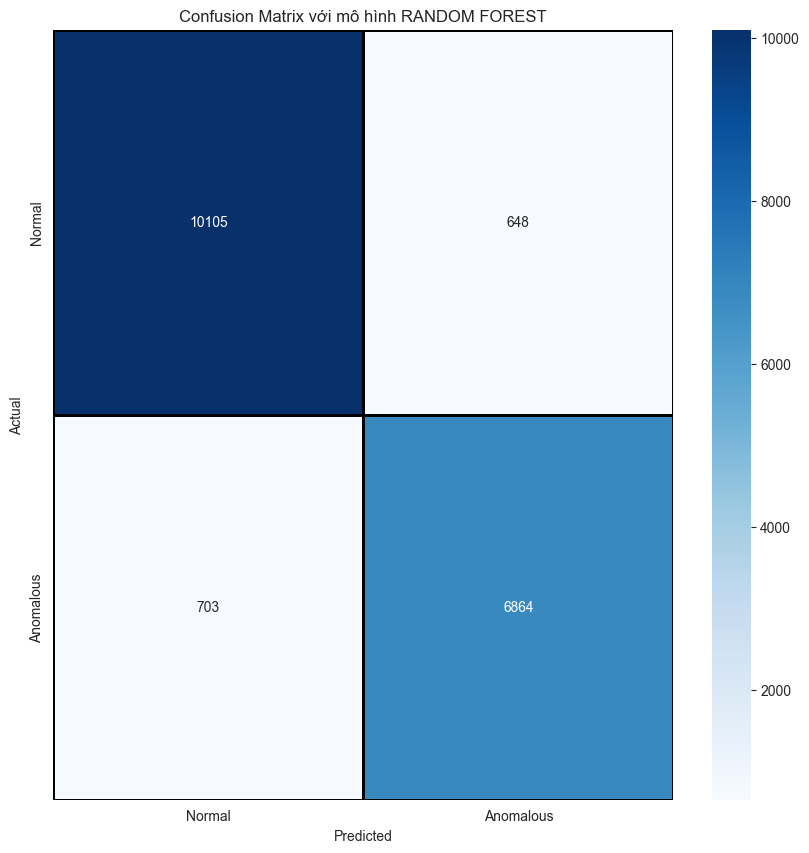

In [30]:
print(classification_report(y_ts, RT_predictions, target_names = ['Normal (class 0)','Anomalous (class 1)']))

plot_confusion_matrix(RT_predictions, y_ts, "RANDOM FOREST")

##### **3.3. Phân loại bất thường với KNN**
Kiểm tra số `n` tốt nhất trong KNN

**GridSearchCV(knn_model, param_grid, cv=5):**
- `GridSearchCV` là một công cụ trong thư viện scikit-learn giúp tìm ra cấu hình tham số tối ưu bằng cách thử nghiệm các kết hợp tham số khác nhau dựa trên không gian tìm kiếm được cung cấp.
- `param_grid`: Đây là không gian tìm kiếm chứa các giá trị của n_neighbors đã được định nghĩa ở bước trước.
- `cv=5`: Thực hiện Cross-Validation với 5 lần gập (folds). Dữ liệu sẽ được chia thành 5 phần và tiến hành huấn luyện và kiểm tra trên mỗi phần để đánh giá độ chính xác của mô hình. Điều này giúp giảm khả năng overfitting.

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

print('----------K-NEAREST NEIGHBOR-----------')
print('1. Tìm giá trị n tốt nhất')

knn_model = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 8, 9, 10, 11, 13, 15, 17, 19]}

grid_search = GridSearchCV(knn_model, param_grid, cv=5)
_ = grid_search.fit(x_tr, y_tr)

best_n_neighbors = grid_search.best_params_['n_neighbors']
print("Giá trị n tốt nhất:", best_n_neighbors)

# In ra tỷ lệ chính xác cho từng giá trị n_neighbors
results = grid_search.cv_results_
print("Giá trị n và các độ chính xác tương ứng:")
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"Giá trị n: {params['n_neighbors']}, \tAccuracy: {mean_score:.5f}")

----------K-NEAREST NEIGHBOR-----------
1. Tìm giá trị n tốt nhất
Giá trị n tốt nhất: 5
Giá trị n và các độ chính xác tương ứng:
Giá trị n: 3, 	Accuracy: 0.91611
Giá trị n: 5, 	Accuracy: 0.91693
Giá trị n: 7, 	Accuracy: 0.91526
Giá trị n: 8, 	Accuracy: 0.91447
Giá trị n: 9, 	Accuracy: 0.91601
Giá trị n: 10, 	Accuracy: 0.91454
Giá trị n: 11, 	Accuracy: 0.91566
Giá trị n: 13, 	Accuracy: 0.91442
Giá trị n: 15, 	Accuracy: 0.91377
Giá trị n: 17, 	Accuracy: 0.91302
Giá trị n: 19, 	Accuracy: 0.91187


Tính toán với tham số `n` tốt nhất

In [32]:
print('----------K-NEAREST NEIGHBOR-----------')
print(f"Bắt đầu train: {datetime.now().strftime('%H:%M:%S')}")
final_model = KNeighborsClassifier(n_neighbors=5)
_ = final_model.fit(x_tr, y_tr)
print(f"Hoàn thành: {datetime.now().strftime('%H:%M:%S')}")

----------K-NEAREST NEIGHBOR-----------
Bắt đầu train: 09:44:44
Hoàn thành: 09:44:44


In [33]:
joblib.dump(final_model, 'knn_model.pkl')
print("Mô hình đã được lưu vào knn_model.pkl")

['knn_model.pkl']

Mô hình đã được lưu vào knn_model.pkl


In [34]:
knn_predictions = final_model.predict(x_ts)
evaluate_model(knn_predictions, y_ts, "KNN")

Chỉ số đánh giá mô hình KNN
Mean absolute error (MAE): 0.08401
Accuracy                 : 0.91599
Prediction               : 0.91595
Recall                   : 0.91599
F1-score                 : 0.91597
ROC AUC                  : 0.91307
Test error               : 0.08401
